<a href="https://colab.research.google.com/github/oamerl/machine-learning-projects/blob/main/Machine-Learning/customer_segmentation_using_pyspark/Customer_Segmentation_Using_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing Needed Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.types import IntegerType
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import ClusteringEvaluator
spark = SparkSession.builder.appName("PySpark").getOrCreate()
# spark

##Data exploration and cleaning

Reading the data and printing the first 5 rows

In [ ]:
# Reading the data
data = spark.read.csv("/FileStore/tables/customer_big_data.csv",
                             inferSchema=True,
                             header=True)

# Printing the first 5 rows of the data
data.toPandas().head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"""RECORD FRAME 7"""" SINGLE SIZE """,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Getting the dataset dimensions

In [ ]:
data.toPandas().shape

Out[81]: (1067371, 8)

Checking the dataset information

In [ ]:
data.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int32         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(4)
memory usage: 61.1+ MB


In [ ]:
data.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)



Checking if any of the features contain null values

In [ ]:
data.toPandas().isna().sum()

Out[84]: Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

Filtering out the null values and rechecking the dataset new dimensions and information

In [ ]:
# Filtering out null customer ids
data_new = data.filter(F.col("Customer ID").isNotNull())

In [ ]:
# Getting the shape of the data
data_new.toPandas().shape

Out[86]: (824364, 8)

In [ ]:
data_new.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824364 entries, 0 to 824363
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int32         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  float64       
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(4)
memory usage: 47.2+ MB


In [ ]:
# Checking if the nulls are removed
data_new.toPandas().isna().sum()

Out[88]: Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

In [ ]:
# Checking the dataset stats
data_new.toPandas().describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
# Checking that the minimum negative of quantity is a cancelled transaction
data_new_df = data_new.toPandas()
data_new_df[(data_new_df["Quantity"]==80995.0) | ((data_new_df["Quantity"]== -80995.0))]


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
823883,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
823884,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


In [ ]:
# Introducing the new coulmn Amount per Transaction
data_new = data_new.withColumn("AmountPerTrans", F.round(F.col("Quantity") * F.col("Price")))

# Reformat invoice date to yyyy-MM-dd to remove the time (hours)
data_new = data_new.withColumn("InvoiceDate", F.to_date(F.col("InvoiceDate"),'MM/dd/yyyy'))

In [ ]:
# Checking the data stats after adding the new column
data_new.toPandas().describe()

,Quantity,Price,Customer ID,AmountPerTrans
count,824364.000000,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504,20.270026
std,188.976099,70.241388,1697.464450,308.685483
min,-80995.000000,0.000000,12346.000000,-168470.000000
25%,2.000000,1.250000,13975.000000,4.000000
50%,5.000000,1.950000,15255.000000,11.000000
75%,12.000000,3.750000,16797.000000,20.000000
max,80995.000000,38970.000000,18287.000000,168470.000000


In [ ]:
"""
# Cancelled Transactions removal
# This function takes so much time so it was not used
def remove_cancelled_transactions(df):
    trans_neg = df.Total < 0
    return df.loc[~(trans_neg | trans_neg.shift(-1))]

data_new_df.rename(columns={"Customer ID": "CustomerID"}, inplace=True)
groups = [data_new_df.CustomerID, data_new_df.StockCode, data_new_df.Total.abs()]
data_new_removed_all_c = data_new_df.groupby(groups, as_index=False, group_keys=False).apply(remove_cancelled_transactions)

"""

Out[93]: '\n# Cancelled Transactions removal \n# This function takes so much time so it was not used\ndef remove_cancelled_transactions(df):\n    trans_neg = df.Total < 0\n    return df.loc[~(trans_neg | trans_neg.shift(-1))]\n\ndata_new_df.rename(columns={"Customer ID": "CustomerID"}, inplace=True)\ngroups = [data_new_df.CustomerID, data_new_df.StockCode, data_new_df.Total.abs()]\ndata_new_removed_all_c = data_new_df.groupby(groups, as_index=False, group_keys=False).apply(remove_cancelled_transactions)\n\n'

In [ ]:
# Printing a sample of data after the addition of the new coulmn of the amount per transaction
data_new.toPandas().head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,AmountPerTrans
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,83.0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"""RECORD FRAME 7"""" SINGLE SIZE """,48,2009-12-01,2.10,13085.0,United Kingdom,101.0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01,1.25,13085.0,United Kingdom,30.0


In [ ]:
data_new.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)
 |-- AmountPerTrans: double (nullable = true)



##Features Extraction

Getting the maximum date that will be used a reference in the our first feature calculation (days passed since last transaction)

In [ ]:
data_new.select(F.max('InvoiceDate')).collect()

Out[96]: [Row(max(InvoiceDate)=datetime.date(2011, 12, 9))]

Adding 1 day to that max date such that the least value of the feature that will be  created to be one day

In [ ]:
latest_date = F.to_date(F.lit("2011/12/10"), 'yyyy/MM/dd')

In [ ]:
# Extracted Feature 1
days_since_last_transaction = (
    data_new.groupBy("Customer ID")
            .agg((F.datediff(latest_date, F.max(F.col("InvoiceDate")))).alias("Days_since_last_transaction"))
)

# Extracted Feature 2
num_of_transactions_per_customer = (
    data_new.groupBy("Customer ID", "Invoice").count()
            .groupBy("Customer ID")
            .agg(F.count("*").alias("Num_Of_Transactions"))
)

# Extracted Feature 3
total_paid_per_customer = (
    data_new.groupBy("Customer ID")
            .agg(F.sum(F.col("AmountPerTrans")).alias("Total_Paid"))
)

# Extarcted Features spark dataframe
extracted_features = (
    days_since_last_transaction.join(num_of_transactions_per_customer, 'Customer ID', how = 'inner')
           .join(total_paid_per_customer,'Customer ID', how = 'inner')
)

In [ ]:
# Getting a data sample of the extracted features
extracted_features.toPandas().head(5)

,Customer ID,Days_since_last_transaction,Num_Of_Transactions,Total_Paid
0,14285.0,22,9,3158.0
1,17884.0,4,23,3062.0
2,16822.0,664,3,144.0
3,16596.0,16,4,585.0
4,17072.0,626,1,285.0


In [ ]:
# Getting the extracted features stats
extracted_features.toPandas().describe()

,Customer ID,Days_since_last_transaction,Num_Of_Transactions,Total_Paid
count,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,203.457085,7.552339,2812.164254
std,1715.451981,211.881245,15.972262,13982.436433
min,12346.000000,1.000000,1.000000,-25111.000000
25%,13831.250000,25.000000,2.000000,328.000000
50%,15316.500000,96.500000,4.000000,850.000000
75%,16801.750000,382.000000,8.000000,2191.000000
max,18287.000000,739.000000,510.000000,598231.000000


In [ ]:
# Removing customers that have a negative value in the total amount paid feature
extracted_features = extracted_features.filter(F.col("Total_Paid") > 0)

In [ ]:
extracted_features.toPandas().describe()

,Customer ID,Days_since_last_transaction,Num_Of_Transactions,Total_Paid
count,5837.000000,5837.000000,5837.000000,5837.000000
mean,15319.615042,197.901833,7.649820,2878.881446
std,1714.977802,207.864821,16.095458,14093.601133
min,12347.000000,1.000000,1.000000,2.000000
25%,13838.000000,25.000000,2.000000,342.000000
50%,15321.000000,93.000000,4.000000,884.000000
75%,16801.000000,376.000000,8.000000,2246.000000
max,18287.000000,739.000000,510.000000,598231.000000


In [ ]:
extracted_features.toPandas().head(5)

,Customer ID,Days_since_last_transaction,Num_Of_Transactions,Total_Paid
0,14285.0,22,9,3158.0
1,17884.0,4,23,3062.0
2,16822.0,664,3,144.0
3,16596.0,16,4,585.0
4,17072.0,626,1,285.0


In [ ]:
# Converting the spark dataframe to pandas to be able to use it in plotting
df_extracted_features = extracted_features.toPandas()

Out[105]: <AxesSubplot:xlabel='Total_Paid', ylabel='Count'>

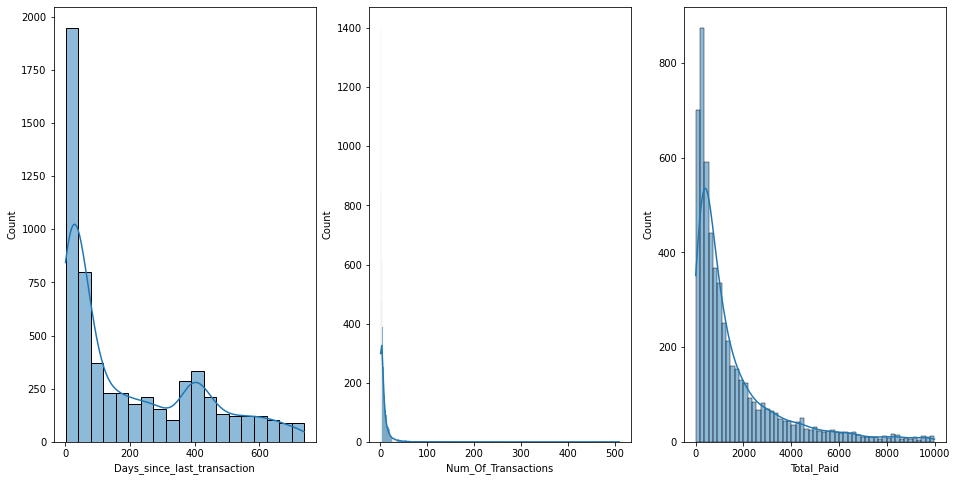

In [ ]:
# Plotting the histogram of the extracted features
fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Feature 1 Histogram - Recency
sns.histplot(df_extracted_features['Days_since_last_transaction'], kde=True, ax=ax[0])

# Feature 2 Histogram - Frequency plot
sns.histplot(df_extracted_features.query('Num_Of_Transactions < 1000')['Num_Of_Transactions'], kde=True, ax=ax[1])

# Feature 3 Histogram - Monetary value plot
sns.histplot(df_extracted_features.query('Total_Paid < 10000')['Total_Paid'], kde=True, ax=ax[2])

##Data Transformation and Scaling

In [ ]:
# Getting the features names to be passed to the vector assembler
features = extracted_features.columns[1:]
features

Out[106]: ['Days_since_last_transaction', 'Num_Of_Transactions', 'Total_Paid']

In [ ]:
# Putting the features in vectorized form to be passed to scaling functions and be used later in model training
assembler = VectorAssembler(
    inputCols=features,
    outputCol="unscaled_features")

assembled_data = assembler.transform(extracted_features)
assembled_data = assembled_data.select('Customer ID', 'unscaled_features')
assembled_data.toPandas().head(5)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field unscaled_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



,Customer ID,unscaled_features
0,14285.0,"[22.0, 9.0, 3158.0]"
1,17884.0,"[4.0, 23.0, 3062.0]"
2,16822.0,"[664.0, 3.0, 144.0]"
3,16596.0,"[16.0, 4.0, 585.0]"
4,17072.0,"[626.0, 1.0, 285.0]"


In [ ]:
# Standardization
standard_scaler = StandardScaler(inputCol='unscaled_features', outputCol='standardized_features')
data_scale = standard_scaler.fit(assembled_data)
standardized_data = data_scale.transform(assembled_data)

standardized_data = standardized_data.withColumn("Customer ID", standardized_data["Customer ID"].cast(IntegerType()))

# Normalization
minmax_scaler = MinMaxScaler(inputCol='standardized_features', outputCol="Normalized_standard_features")
data_scale_2 = minmax_scaler.fit(standardized_data)
normalized_standard_data = data_scale_2.transform(standardized_data)
normalized_standard_data.toPandas().head(5)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning:

toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field unscaled_features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.



,Customer ID,unscaled_features,standardized_features,Normalized_standard_features
0,14285,"[22.0, 9.0, 3158.0]","[0.10583801470115865, 0.5591639429672356, 0.22...","[0.028455284552845534, 0.015717092337917484, 0..."
1,17884,"[4.0, 23.0, 3062.0]","[0.019243275400210664, 1.4289745209162688, 0.2...","[0.0040650406504065045, 0.04322200392927309, 0..."
2,16822,"[664.0, 3.0, 144.0]","[3.19438371643497, 0.18638798098907855, 0.0102...","[0.8983739837398376, 0.003929273084479372, 0.0..."
3,16596,"[16.0, 4.0, 585.0]","[0.07697310160084266, 0.24851730798543806, 0.0...","[0.020325203252032523, 0.005893909626719058, 0..."
4,17072,"[626.0, 1.0, 285.0]","[3.011572600132969, 0.062129326996359514, 0.02...","[0.8468834688346885, 0.0, 0.00047306299092822316]"


##K-Means Clustering Model Building

In [ ]:
# Clustering with different values of K to identify appropriate value
# Searing for the best value of K through Elbow curve and Silhouette score analysis
#tune_seed = 144 # random seed

costs = {} # inertia cost
silhouette_scores = {}
silhouette_score_evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='Normalized_standard_features',
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')
for k in range(2, 11):
    k_means_pp = KMeans(featuresCol='Normalized_standard_features', k=k,initMode = 'k-means||')
    model = k_means_pp.fit(normalized_standard_data)
    prediction_output = model.transform(normalized_standard_data)
    score = silhouette_score_evaluator.evaluate(prediction_output)
    silhouette_scores[k] = score
    costs[k] = model.summary.trainingCost

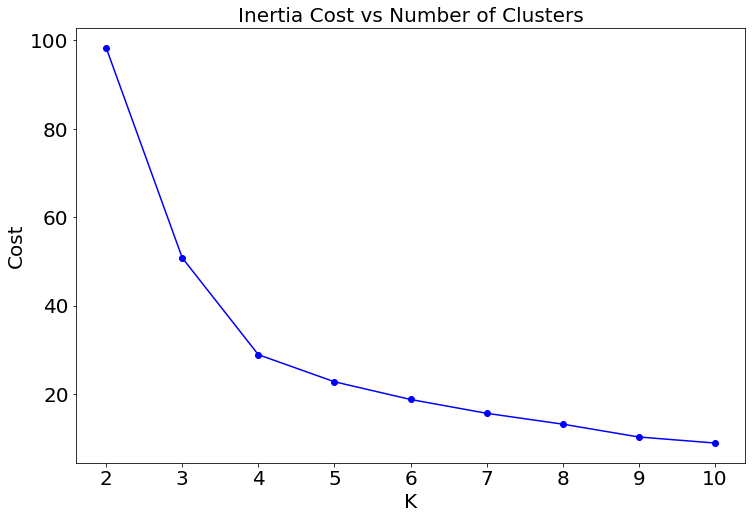

In [ ]:
# Plotting the Elbow curve (inertia cost for different values of K)
fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(list(costs.keys()), list(costs.values()), '-ob')
ax.set_xlabel('K', fontsize =20)
ax.set_ylabel('Cost', fontsize =20)
ax.set_title('Inertia Cost vs Number of Clusters', fontsize =20)
ax.tick_params(labelsize =20)

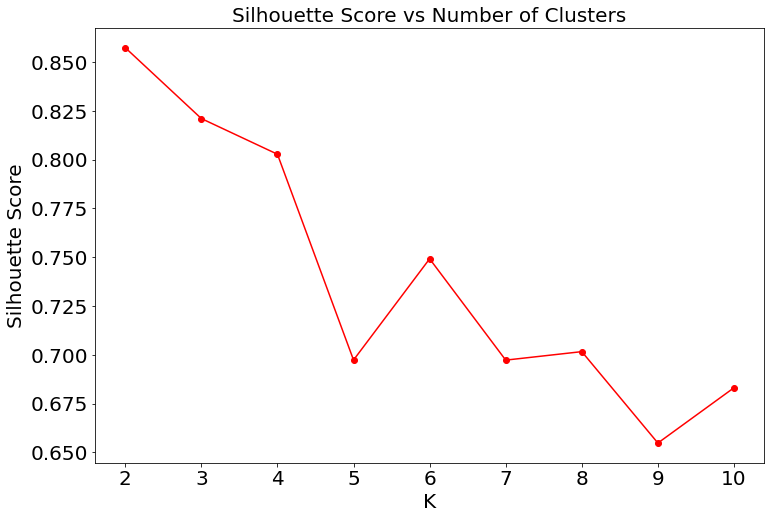

In [ ]:
# Plotting the silhouette score for different values of K
fig, ax = plt.subplots(1, 1, figsize =(12, 8))
ax.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), '-or')
ax.set_xlabel('K',fontsize =20)
ax.set_ylabel('Silhouette Score', fontsize =20)
ax.set_title('Silhouette Score vs Number of Clusters',fontsize =20)
ax.tick_params(labelsize =20)

##Model fitting with K = 6 as discussed in the report.

In [ ]:
# Fitting the model with the chosen K
#train_seed = tune_seed # same seed used during finding the best K

k = 6 # number of clusters
k_means_pp = KMeans(featuresCol='Normalized_standard_features', k=k, initMode = 'k-means||')
model = k_means_pp.fit(normalized_standard_data)
predictions = model.transform(normalized_standard_data)

In [ ]:
# Customer class assignment results after model fitting
result = predictions.select('Customer ID', 'prediction')
result.toPandas().head(5)

,Customer ID,prediction
0,14285,0
1,17884,0
2,16822,1
3,16596,0
4,17072,1


In [ ]:
# Converting the vectorized scaled features back to the array format
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# Spark dataframe of the normalized standardized features
normalized_standard_features_matrix = (normalized_standard_data.withColumn("feature", vector_to_array("Normalized_standard_features"))).select(["Customer ID"] + [col("feature")[i] for i in range(3)])

# Printing a sample of the scaled features
normalized_standard_features_matrix.toPandas().head(5)

#{"feature[0]": "Days_since_last_transaction_scaled"}
#{"feature[1]": "Num_Of_Transactions_scaled"}
#{"feature[2]": "Total_Paid_scaled"}


,Customer ID,feature[0],feature[1],feature[2]
0,14285,0.028455,0.015717,0.005276
1,17884,0.004065,0.043222,0.005115
2,16822,0.898374,0.003929,0.000237
3,16596,0.020325,0.005894,0.000975
4,17072,0.846883,0.000000,0.000473


In [ ]:
# Combining these scaled features and the prediction value (class assignment) with the unscaled features spark dataframe
combined_result_table = result.join(extracted_features, on='Customer ID', how='inner').join(normalized_standard_features_matrix, on='Customer ID', how='inner')

# Printing a sample of the combined spark dataframe
combined_result_table.toPandas().head(5)

,Customer ID,prediction,Days_since_last_transaction,Num_Of_Transactions,Total_Paid,feature[0],feature[1],feature[2]
0,14285,0,22,9,3158.0,0.028455,0.015717,0.005276
1,17884,0,4,23,3062.0,0.004065,0.043222,0.005115
2,16822,1,664,3,144.0,0.898374,0.003929,0.000237
3,16596,0,16,4,585.0,0.020325,0.005894,0.000975
4,17072,1,626,1,285.0,0.846883,0.000000,0.000473


In [ ]:
# Converting the sparkdataframe to pandas df and renaming the scaled features columns
combined_result_table_df = combined_result_table.toPandas()
combined_result_table_df.rename(columns={"feature[0]": "Days_since_last_transaction_scaled", "feature[1]": "Num_Of_Transactions_scaled", "feature[2]": "Total_Paid_scaled" }, inplace=True)

# Printing a sample of the combined dataframe after adjsuting the names of the scaled features
combined_result_table_df.head(6)


,Customer ID,prediction,Days_since_last_transaction,Num_Of_Transactions,Total_Paid,Days_since_last_transaction_scaled,Num_Of_Transactions_scaled,Total_Paid_scaled
0,14285,0,22,9,3158.0,0.028455,0.015717,0.005276
1,17884,0,4,23,3062.0,0.004065,0.043222,0.005115
2,16822,1,664,3,144.0,0.898374,0.003929,0.000237
3,16596,0,16,4,585.0,0.020325,0.005894,0.000975
4,17072,1,626,1,285.0,0.846883,0.000000,0.000473
5,14452,0,11,4,679.0,0.013550,0.005894,0.001132


##Visualizations

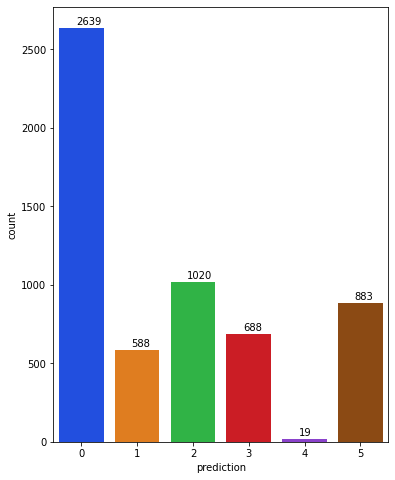

In [ ]:
# Plotting customer distribution across different customer segments
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="prediction", data=combined_result_table_df,palette="bright", )
#ax.tick_params(labelsize =20)
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 20))

Out[147]: <AxesSubplot:xlabel='Num_Of_Transactions_scaled', ylabel='Total_Paid_scaled'>

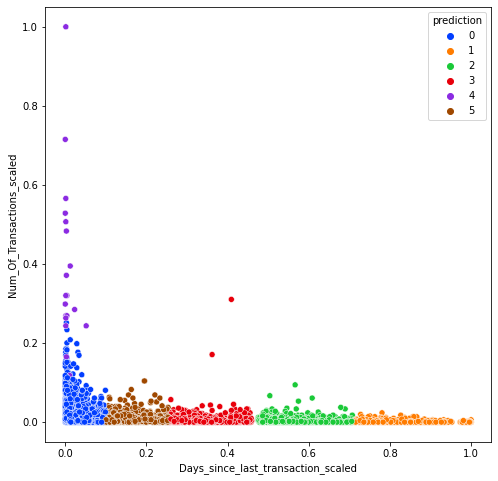

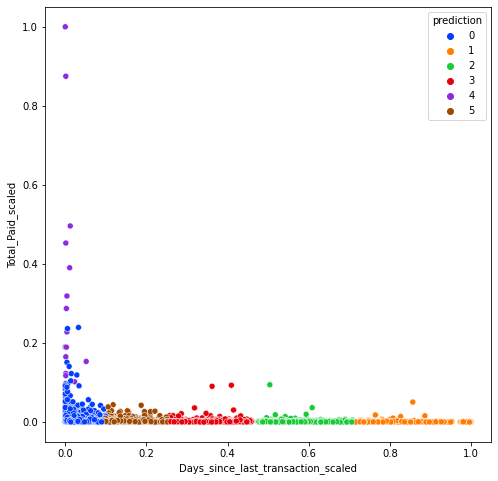

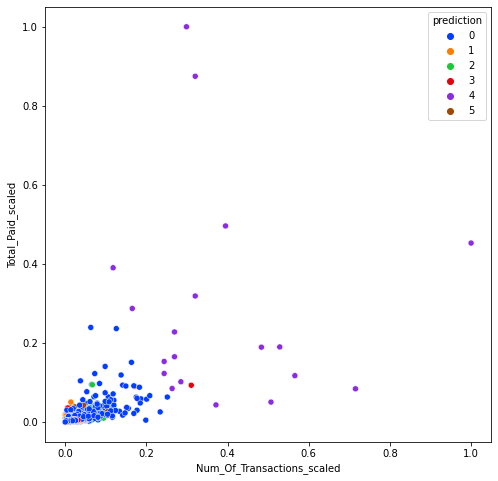

In [ ]:
#Plotting the scaled features against each other

# Feature 1 VS Feature 2
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Days_since_last_transaction_scaled', y='Num_Of_Transactions_scaled', data=combined_result_table_df, hue='prediction', palette="bright")
#ax.tick_params(labelsize =20)

# Feature 1 VS Feature 3
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Days_since_last_transaction_scaled', y='Total_Paid_scaled', data=combined_result_table_df, hue='prediction', palette="bright")
#ax.tick_params(labelsize =20)

# Feature 2 VS Feature 3
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Num_Of_Transactions_scaled', y='Total_Paid_scaled', data=combined_result_table_df, hue='prediction', palette="bright")
#ax.tick_params(labelsize =20)

In [ ]:
# Plotting the features against each other in the 3D space since they are only 3 features
import plotly.express as px
combined_result_table_df["prediction"] = combined_result_table_df["prediction"].astype(str) #for discrete colours
fig = px.scatter_3d(data_frame = combined_result_table_df,
                    x='Days_since_last_transaction',
                    y='Num_Of_Transactions',
                    z='Total_Paid',
                    color='prediction',
                   color_discrete_sequence=px.colors.qualitative.D3,
                   category_orders={"prediction": ["0","1","2", "3","4"]})
fig.show()


Out[149]: <AxesSubplot:xlabel='prediction', ylabel='Total_Paid'>

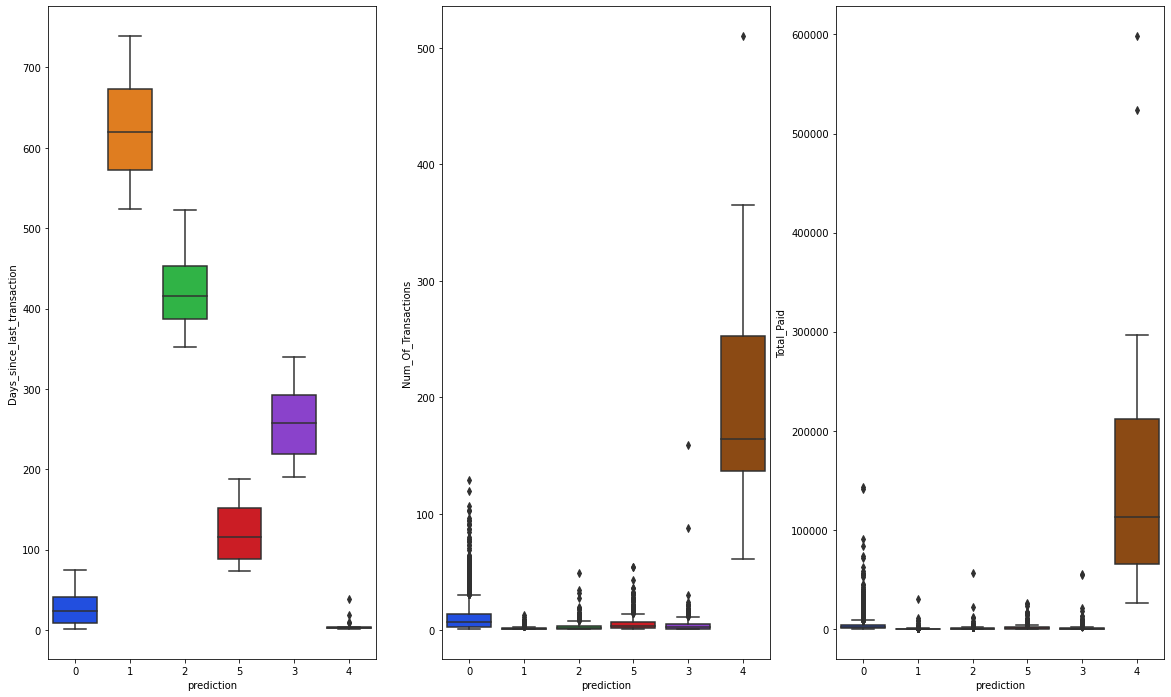

In [ ]:
# Plotting the Box Plot of each feature
fig4, ax4 = plt.subplots(1,3, figsize=(20, 12))
ax.tick_params(labelsize =10)
#fig4.tight_layout(pad=5.0)

sns.boxplot(x='prediction', y='Days_since_last_transaction', data = combined_result_table_df, ax=ax4[0], palette="bright") # feature 1 box plot
sns.boxplot(x='prediction', y='Num_Of_Transactions', data = combined_result_table_df, ax=ax4[1], palette="bright") # feature 2 box plot
sns.boxplot(x='prediction', y='Total_Paid', data = combined_result_table_df, ax=ax4[2], palette="bright") # feature 3 box plot

In [ ]:
# experimenting with filtering the customers using their assigned class
combined_result_table.filter(F.col("prediction") == 2).toPandas().head(5)

,Customer ID,prediction,Days_since_last_transaction,Num_Of_Transactions,Total_Paid,feature[0],feature[1],feature[2]
0,17032,2,442,13,2183.0,0.597561,0.023576,0.003646
1,16858,2,367,16,4444.0,0.495935,0.029470,0.007425
2,16331,2,433,6,2045.0,0.585366,0.009823,0.003415
3,17343,2,356,6,1270.0,0.481030,0.009823,0.002120
4,14478,2,383,4,1280.0,0.517615,0.005894,0.002136
